# EN3160 Assignment 2 on Fitting and Alignment


In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

1. In this question, using the knowledge on blob detection, i.e., using Laplacian of Gaussians and scale-space extrema detection, we will detect and draw circles in the sunflower field image. Use the sunflower field image provided: im = cv.imread(’images/the_berry_farms_sunflower_field.jpeg’, cv.IMREAD_REDUCED_COLOR_4) Report the parameters of the largest circles. Report the range of σ values used. You may not use the cv2.HoughCircles function.

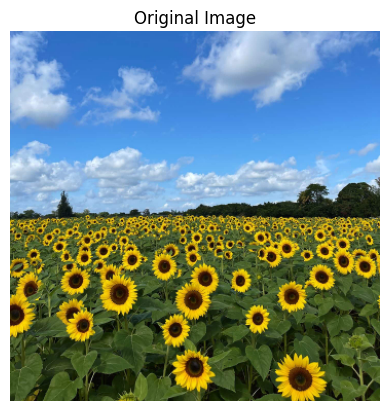

In [2]:
img = cv.imread('images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY).astype(np.float64) / 255.0

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

In [3]:
# sigma values for Gaussian blur
sigma_min = 0.5
sigma_max = 8.0
num_scales = 15
sigma_values = np.linspace(sigma_min, sigma_max, num_scales)

print("Processing scales with sigma values:")
print(sigma_values)

Processing scales with sigma values:
[0.5        1.03571429 1.57142857 2.10714286 2.64285714 3.17857143
 3.71428571 4.25       4.78571429 5.32142857 5.85714286 6.39285714
 6.92857143 7.46428571 8.        ]


In [4]:
blob_list = []
response_images = []

for sigma in sigma_values:
    print(f"Sigma value = {sigma:.2f}")
    
    kernel_size = int(2 * np.ceil(3 * sigma) + 1)
    half_size = kernel_size // 2
    
    x, y = np.meshgrid(np.arange(-half_size, half_size + 1), 
                       np.arange(-half_size, half_size + 1))
    
    sigma_sq = sigma ** 2
    gaussian = np.exp(-(x**2 + y**2) / (2 * sigma_sq))
    log_kernel = -1 / (np.pi * sigma**4) * (1 - (x**2 + y**2) / (2 * sigma_sq)) * gaussian
    log_kernel = (sigma ** 2) * log_kernel

    response = cv.filter2D(img_gray, cv.CV_64F, log_kernel)
    response = response ** 2
    response_images.append(response)

    neighborhood_size = 3
    threshold_value = 0.08  
    H, W = response.shape
    for i in range(neighborhood_size, H - neighborhood_size):
        for j in range(neighborhood_size, W - neighborhood_size):
            local_region = response[i-neighborhood_size:i+neighborhood_size+1, 
                                   j-neighborhood_size:j+neighborhood_size+1]
            if response[i, j] == np.max(local_region) and response[i, j] > threshold_value:
                radius = int(sigma * np.sqrt(2))
                blob_list.append((j, i, radius, sigma))  

print(f"\nTotal number of blobs detected: {len(blob_list)}")

Sigma value = 0.50
Sigma value = 1.04
Sigma value = 1.57
Sigma value = 2.11
Sigma value = 2.64
Sigma value = 3.18
Sigma value = 3.71
Sigma value = 4.25
Sigma value = 4.79
Sigma value = 5.32
Sigma value = 5.86
Sigma value = 6.39
Sigma value = 6.93
Sigma value = 7.46
Sigma value = 8.00

Total number of blobs detected: 925


In [5]:
blobs = blob_list
max_distance = 15

blobs_array = np.array(blobs)
unique_blobs = []
used = np.zeros(len(blobs), dtype=bool)

for i in range(len(blobs)):
    if used[i]:
        continue
    x1, y1, r1, s1 = blobs[i]
    current_best = blobs[i]
    used[i] = True

    for j in range(i + 1, len(blobs)):
        if used[j]:
            continue
        x2, y2, r2, s2 = blobs[j]
        distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        if distance < max_distance:
            used[j] = True
            if r2 > current_best[2]:
                current_best = blobs[j]
    unique_blobs.append(current_best)

filtered_blobs = unique_blobs
print(f"Number of blobs after removing duplicates: {len(filtered_blobs)}")


Number of blobs after removing duplicates: 180


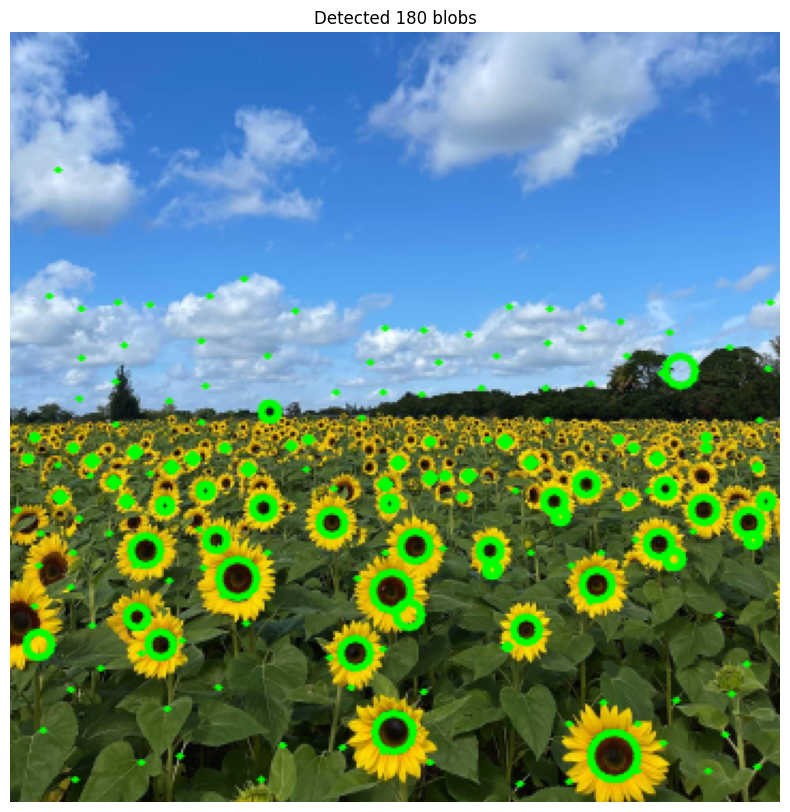

In [6]:
output_img = img.copy()  

for x, y, radius, sigma in filtered_blobs:
    cv.circle(output_img, (int(round(x)), int(round(y))), int(round(radius)), (0, 255, 0), 2, lineType=cv.LINE_AA)

plt.figure(figsize=(12, 10))
plt.imshow(cv.cvtColor(output_img, cv.COLOR_BGR2RGB))
plt.title(f'Detected {len(filtered_blobs)} blobs')
plt.axis('off')
plt.show()


Parameters of the largest circle detected:
Sigma: 8.00
Location: (282, 338)
Radius: 11 pixels


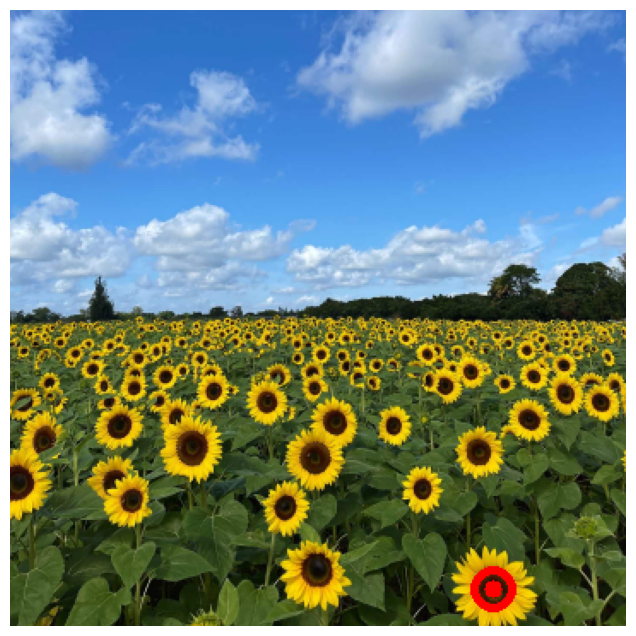

In [7]:
largest_blob = max(filtered_blobs, key=lambda x: x[2])
x_largest, y_largest, r_largest, sigma_largest = largest_blob

print("Parameters of the largest circle detected:")
print(f"Sigma: {sigma_largest:.2f}")
print(f"Location: ({x_largest}, {y_largest})")
print(f"Radius: {r_largest} pixels")


output_largest = cv.cvtColor(img, cv.COLOR_BGR2RGB).copy()
cv.circle(output_largest, (int(x_largest), int(y_largest)), int(r_largest), (255, 0, 0), 3)
cv.circle(output_largest, (int(x_largest), int(y_largest)), 5, (255, 0, 0), -1)

plt.figure(figsize=(10, 8))
plt.imshow(output_largest)
plt.axis('off')
plt.show()

2. In this question, we will fit a line and, subsequently, a circle to a set of noisy points that conform to a line
and a circle. The code snippet in Listing 1 shows the code to generate this noisy point set X amounting to a
circle and a line. We can characterize a line with three parameters a,b,d where [a,b]⊺ is the unit normal to
the line adn d is the perpendicular distance from the origin (see the slide on total least squares line fitting).
We can parameterize a circle using the center [x, y]⊺ and the radius r. Given a set of inliers (points that we
know belong to a model, e.g., a circle) we can estimate the best fitting model (best circle) using an optimizer
like scipy.minimize (see the documentation). To learn a little of the problem setting in optimization, read
the section 1.1 of Boyd and Vandenberghe. We find the inliers within the framework of RANSAC. Consider
the noisy pointset X.

(a) Estimate the line using the RNASAC algorithm (must be coded on your own). Ensure that you apply
the constraint ∥[a,b]⊺∥ = 1. Carefully select the error (the normal distance to the estimated line) and
the number of points that must be in the consensus.

(b) Subtract the consensus of the best line and estimate the circle that fits the remnant using RANSAC.
Carefully select the threshold of error (radial error) and the number of points that must be in the
consensus.

(c) Show in the same plot, the point set, the line estimated from the sample leading to the best estimate,
the circle estimated from the sample leading to the best estimate, this sample of three points, the best
fit line, line inliers, the the best-fit circle and circle inliers. See Figure 1 for an example.

(d) What will happen if we fit the circle first?

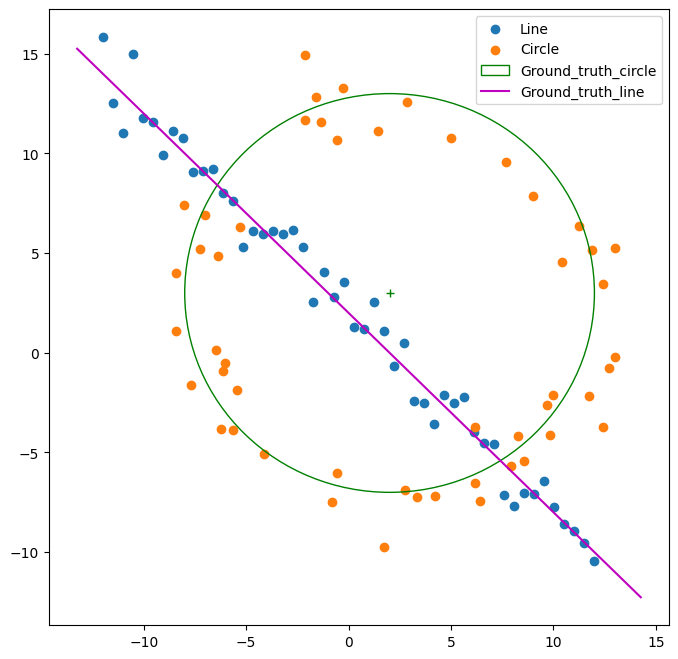

In [19]:
# Generation of a Noisy Point Set Conforming to a Line and a Circle
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
#import tikzplotlib
#np.random.seed(0)

N = 100
half_n = int(N/2)
r = 10
x0_gt, y0_gt = 2, 3 # Center
s = r /16
t = np.random.uniform(0, 2*np.pi, half_n)
n = np.random.randn(half_n) 
x, y = x0_gt + ( r + n)* np.cos(t), y0_gt + ( r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1
m, b = -1, 2
x = np.linspace( -12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line)) # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:,0], X_line[:,1], label='Line')
ax.scatter(X_circ[:,0], X_circ[:,1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y = m*x_ + b
plt.plot(x_, y, color='m', label='Ground_truth_line')
plt.legend()


In [36]:
data_points = X
iterations = 1000
threshold = 0.5
min_support = 30

best_model = None
max_support_count = 0
best_inlier_points = None
chosen_pair = None

for t in range(iterations):
    sample_indices = np.random.choice(len(data_points), 2, replace=False)
    p1, p2 = data_points[sample_indices]

    direction_vec = p2 - p1
    normal_vec = np.array([-direction_vec[1], direction_vec[0]])
    norm_val = np.linalg.norm(normal_vec)

    if norm_val < 1e-10:
        continue  

    a = normal_vec[0] / norm_val
    b = normal_vec[1] / norm_val
    d = -(a * p1[0] + b * p1[1])

    point_distances = np.abs(a * data_points[:, 0] + b * data_points[:, 1] + d)

    inlier_mask = point_distances < threshold
    current_inliers = data_points[inlier_mask]
    num_inliers = len(current_inliers)

    if num_inliers > max_support_count and num_inliers >= min_support:
        max_support_count = num_inliers
        best_model = (a, b, d)
        best_inlier_points = current_inliers
        chosen_pair = np.array([p1, p2])


a, b, d = best_model
print("\nRANSAC Line Fit")
print(f"Inliers detected: {max_support_count}")
print(f"Line equation: {a:.4f}x + {b:.4f}y + {d:.4f} = 0")
print(f"Normalization check: a^2 + b^2 = {a**2 + b**2:.6f}")


RANSAC Line Fit
Inliers detected: 32
Line equation: 0.7093x + 0.7049y + -1.5003 = 0
Normalization check: a^2 + b^2 = 1.000000


In [ ]:
filtered_pts = np.array([
    p for p in X if not any(np.array_equal(p, q) for q in best_inlier_points)
])
print(f"\nRemaining points after filtering line inliers: {len(filtered_pts)}")

iterations = 1000
radius_tolerance = 1.5
min_support = 45


best_center = None
best_radius = None
strongest_inliers = []
best_triplet = None

total_points = len(filtered_pts)

for step in range(iterations):
    chosen_idx = np.random.choice(total_points, 3, replace=False)
    A, B, C = filtered_pts[chosen_idx]

    AB = B - A
    AC = C - A

    ab_sq = AB[0]**2 + AB[1]**2
    ac_sq = AC[0]**2 + AC[1]**2

    determinant = 2 * (AB[0] * AC[1] - AB[1] * AC[0])
    if abs(determinant) < 1e-10:
        continue  

    cx = A[0] + (ab_sq * AC[1] - ac_sq * AB[1]) / determinant
    cy = A[1] + (ac_sq * AB[0] - ab_sq * AC[0]) / determinant
    radius = np.sqrt((A[0] - cx)**2 + (A[1] - cy)**2)

    dist_to_circle = np.abs(np.sqrt((filtered_pts[:, 0] - cx)**2 +
                                    (filtered_pts[:, 1] - cy)**2) - radius)

    inlier_mask = dist_to_circle < radius_tolerance
    current_inliers = filtered_pts[inlier_mask]

    if len(current_inliers) > len(strongest_inliers) and len(current_inliers) >= min_support:
        strongest_inliers = current_inliers
        best_center = (cx, cy)
        best_radius = radius
        best_triplet = np.array([A, B, C])


x_c, y_c = best_center
print("\n====== Circle Fitting Summary ======")
print(f"Inliers detected: {len(strongest_inliers)}")
print(f"Center: ({x_c:.4f}, {y_c:.4f})")
print(f"Estimated radius: {best_radius:.4f}")



Remaining points after filtering line inliers: 68

====== Circle Fitting Summary ======
Inliers detected: 45
Center: (2.2193, 2.4395)
Estimated radius: 10.0595


C:\Users\pasin\AppData\Local\Temp\ipykernel_50760\1220900036.py:13: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(best_triplet[:, 0], best_triplet[:, 1], color='darkblue', s=200,


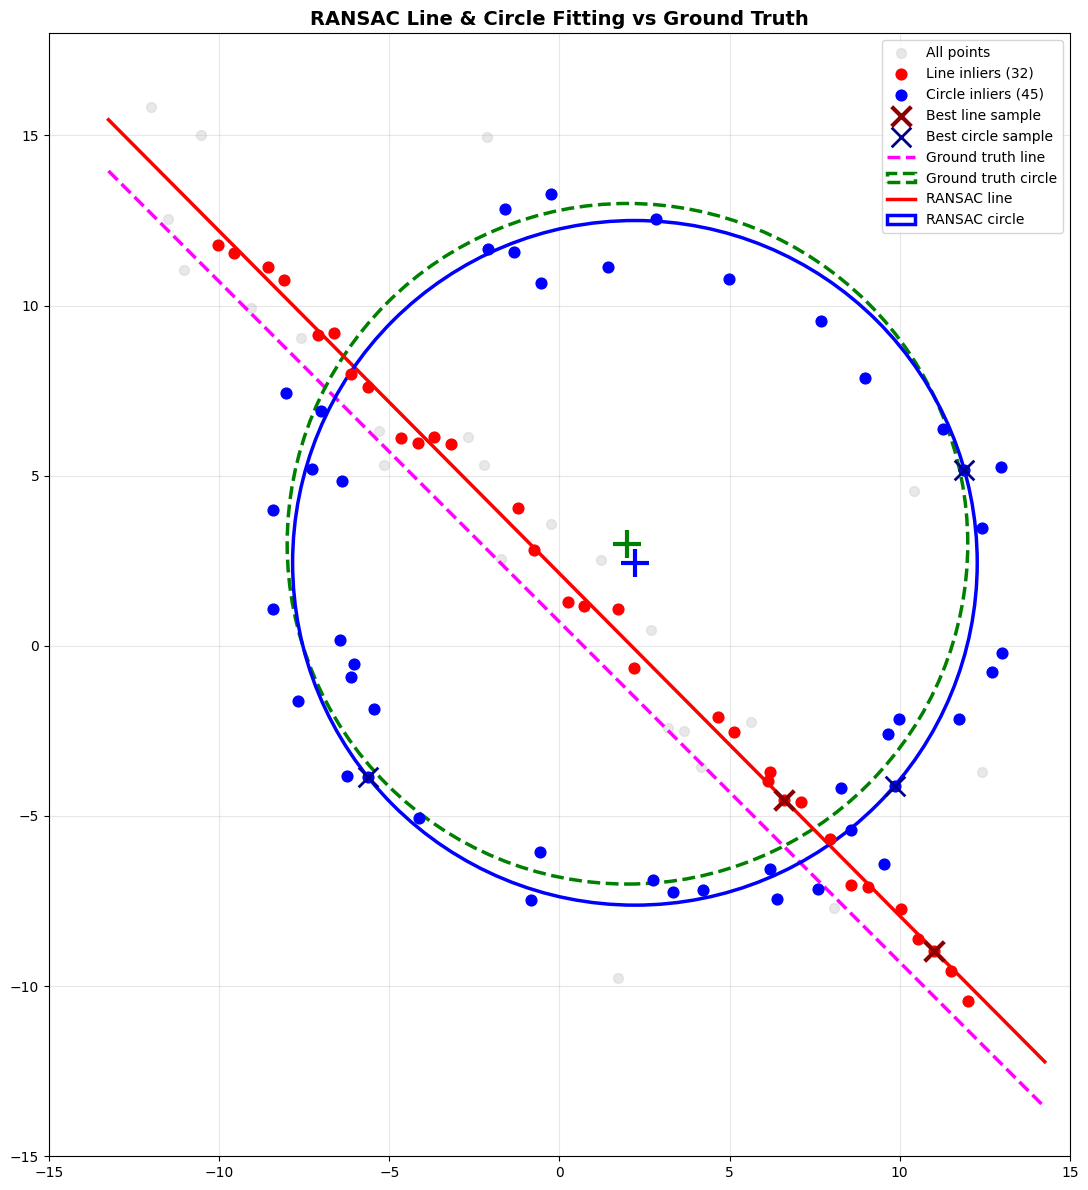


GROUND TRUTH vs RANSAC RESULTS
Line slope (ground truth): -1
Line slope (RANSAC): -1.0061

Circle center (ground truth): (2, 3)
Circle center (RANSAC): (2.2193, 2.4395)
Circle radius (ground truth): 10
Circle radius (RANSAC): 10.0595


In [49]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(X[:, 0], X[:, 1], color='lightgray', s=50, alpha=0.5, label='All points', zorder=1)

ax.scatter(best_inlier_points[:, 0], best_inlier_points[:, 1], color='red', s=60,
           marker='o', label=f'Line inliers ({len(best_inlier_points)})', zorder=3)

ax.scatter(strongest_inliers[:, 0], strongest_inliers[:, 1], color='blue', s=60,
           marker='o', label=f'Circle inliers ({len(strongest_inliers)})', zorder=3)

ax.scatter(chosen_pair[:, 0], chosen_pair[:, 1], color='darkred', s=200,
           marker='x', linewidth=3, label='Best line sample', zorder=5)
ax.scatter(best_triplet[:, 0], best_triplet[:, 1], color='darkblue', s=200,
           marker='x', edgecolors='black', linewidth=2, label='Best circle sample', zorder=5)

y_gt_line = m * np.array([x_min, x_max]) + b
ax.plot([x_min, x_max], y_gt_line, color='magenta', linewidth=2.5, linestyle='--', label='Ground truth line', zorder=2)

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='green', fill=False, linewidth=2.5, linestyle='--', label='Ground truth circle', zorder=2)
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, 'g+', markersize=20, markeredgewidth=3, zorder=4)

y_ransac = -(a * np.array([x_min, x_max]) + d) / b
ax.plot([x_min, x_max], y_ransac, color='red', linewidth=2.5, label='RANSAC line', zorder=2)

circle_ransac = plt.Circle(best_center, best_radius, color='blue', fill=False, linewidth=2.5,
                           label='RANSAC circle', zorder=2)
ax.add_patch(circle_ransac)
ax.plot(x_c, y_c, 'b+', markersize=20, markeredgewidth=3, zorder=4)

# Axis settings
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 18)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10)
ax.set_title('RANSAC Line & Circle Fitting vs Ground Truth', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("GROUND TRUTH vs RANSAC RESULTS")
print("="*60)
print(f"Line slope (ground truth): {m}")
print(f"Line slope (RANSAC): {-a/b:.4f}")
print(f"\nCircle center (ground truth): ({x0_gt}, {y0_gt})")
print(f"Circle center (RANSAC): ({x_c:.4f}, {y_c:.4f})")
print(f"Circle radius (ground truth): {r}")
print(f"Circle radius (RANSAC): {best_radius:.4f}")
print("="*60)

3. Figure 2 shows an architectural image1 with a flag 2 superimposed. This is done by clicking four points on a
planar surface in the architectural image, computing a homography that maps the flag image to this plane,
and warping the flag, and blending on to the architectural image. Carry this out for a couple of image pairs
of you own choice. You may explain the (non-technical) rationale of your choice.

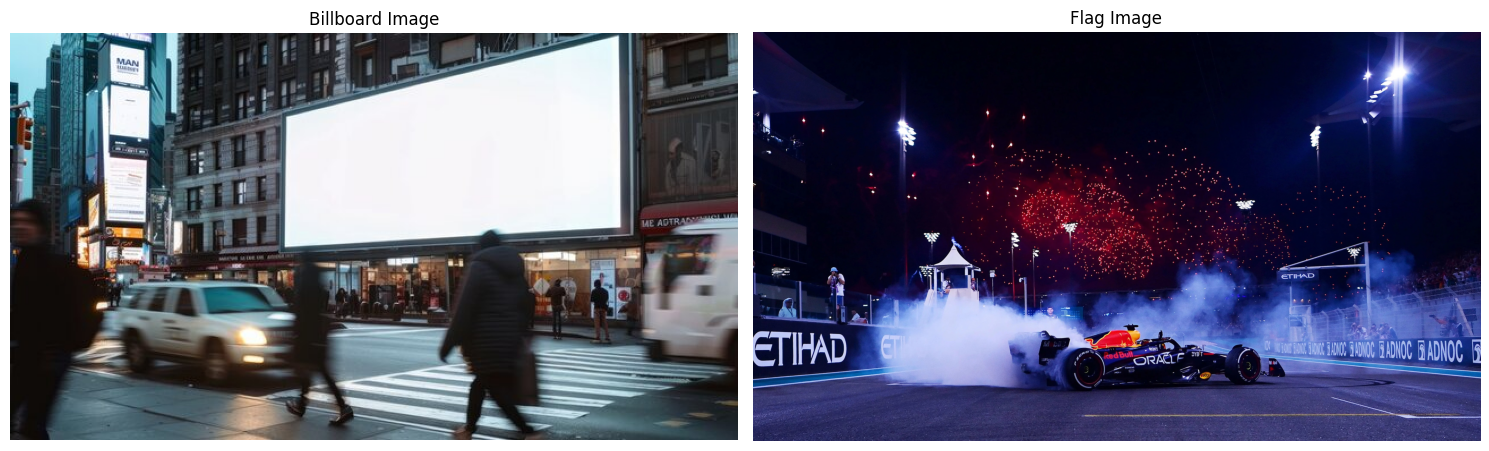

Billboard image shape: (360, 643, 3)
Flag image shape: (1908, 3392, 3)


In [66]:
billboard_img = cv.imread('images/time_square.jpg')  
flag_img = cv.imread('images/red_bull.jpg') 

billboard_rgb = cv.cvtColor(billboard_img, cv.COLOR_BGR2RGB)
flag_rgb = cv.cvtColor(flag_img, cv.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].imshow(billboard_rgb)
axes[0].set_title('Billboard Image')
axes[0].axis('off')

axes[1].imshow(flag_rgb)
axes[1].set_title('Flag Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Billboard image shape: {billboard_img.shape}")
print(f"Flag image shape: {flag_img.shape}")

In [67]:
corner_points = []

display_img = billboard_img.copy()

print("\nPlease click on the 4 corners of the billboard for the flag placement")
print("Order: Top-left, Top-right, Bottom-right, Bottom-left")

def handle_click(event, x, y, flags, img):
    if event == cv.EVENT_LBUTTONDOWN and len(corner_points) < 4:
        corner_points.append([x, y])
        print(f"Corner {len(corner_points)} selected at ({x}, {y})")
        
        cv.circle(img, (x, y), 5, (0, 255, 0), -1)
        cv.putText(img, str(len(corner_points)), (x + 10, y + 10),
                   cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv.imshow('Select Corners', img)

cv.namedWindow('Select Corners')
cv.setMouseCallback('Select Corners', handle_click, display_img)
cv.imshow('Select Corners', display_img)
cv.waitKey(0)
cv.destroyAllWindows()

print(f"\nFinal selected points: {corner_points}")



Please click on the 4 corners of the billboard for the flag placement
Order: Top-left, Top-right, Bottom-right, Bottom-left
Corner 1 selected at (243, 74)
Corner 2 selected at (540, 2)
Corner 3 selected at (541, 173)
Corner 4 selected at (241, 190)

Final selected points: [[243, 74], [540, 2], [541, 173], [241, 190]]


In [79]:
points_billboard = [[243, 75], [537, 2], [540, 173], [241, 191]]
pts_billboard = np.array(points_billboard, dtype=np.float32)

h_flag, w_flag = flag_img.shape[:2]
pts_flag = np.array([[0, 0], 
                     [w_flag, 0], 
                     [w_flag, h_flag], 
                     [0, h_flag]], dtype=np.float32)

print(f"Source points (flag corners):\n{pts_flag}")
print(f"\nDestination points (billboard):\n{pts_billboard}")

H, status = cv.findHomography(pts_flag, pts_billboard)

print(f"\nHomography Matrix:\n{H}")
print(f"\nHomography status: {status}")

Source points (flag corners):
[[   0.    0.]
 [3392.    0.]
 [3392. 1908.]
 [   0. 1908.]]

Destination points (billboard):
[[243.  75.]
 [537.   2.]
 [540. 173.]
 [241. 191.]]

Homography Matrix:
[[ 3.55302678e-02 -2.75101169e-03  2.43000000e+02]
 [-2.17117078e-02  5.94471287e-02  7.50000000e+01]
 [-9.52407086e-05 -7.06553387e-06  1.00000000e+00]]

Homography status: [[1]
 [1]
 [1]
 [1]]


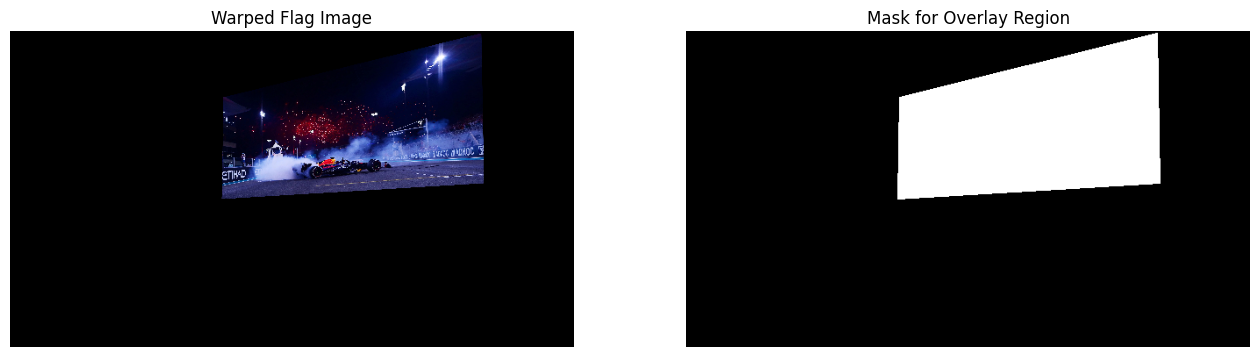

In [ ]:
h_billboard, w_billboard = billboard_img.shape[:2]
warped_flag = cv.warpPerspective(flag_img, H, (w_billboard, h_billboard))

mask = np.zeros_like(billboard_img, dtype=np.uint8)
cv.fillConvexPoly(mask, pts_billboard.astype(np.int32), (255, 255, 255))

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(cv.cvtColor(warped_flag, cv.COLOR_BGR2RGB))
axes[0].set_title('Warped Flag Image')
axes[0].axis('off')

axes[1].imshow(cv.cvtColor(mask, cv.COLOR_BGR2RGB))
axes[1].set_title('Mask')
axes[1].axis('off')

plt.show()


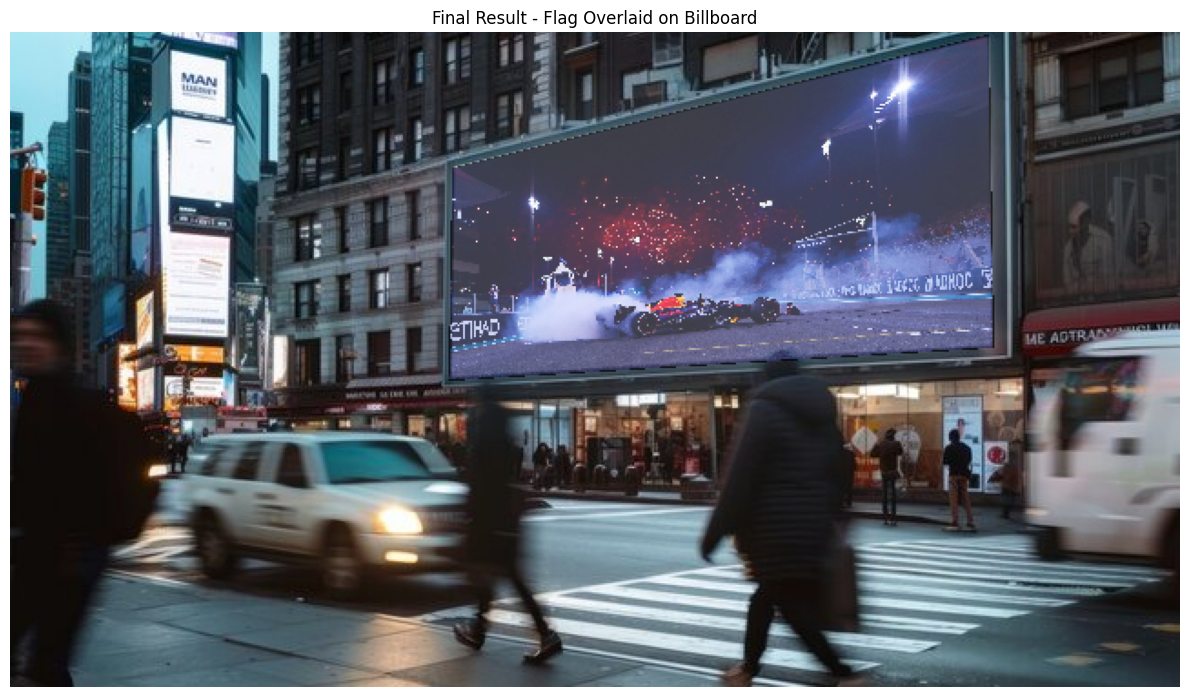

In [87]:
alpha = 0.75
result = billboard_img.copy()
for i in range(3):  
    result[:, :, i] = np.where(mask[:, :, i] > 0,
                               cv.addWeighted(billboard_img[:, :, i], 1-alpha, 
                                             warped_flag[:, :, i], alpha, 0),
                               billboard_img[:, :, i])
    
plt.figure(figsize=(12, 10))
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.title('Final Result - Flag Overlaid on Billboard')
plt.axis('off')
plt.tight_layout()
plt.show()

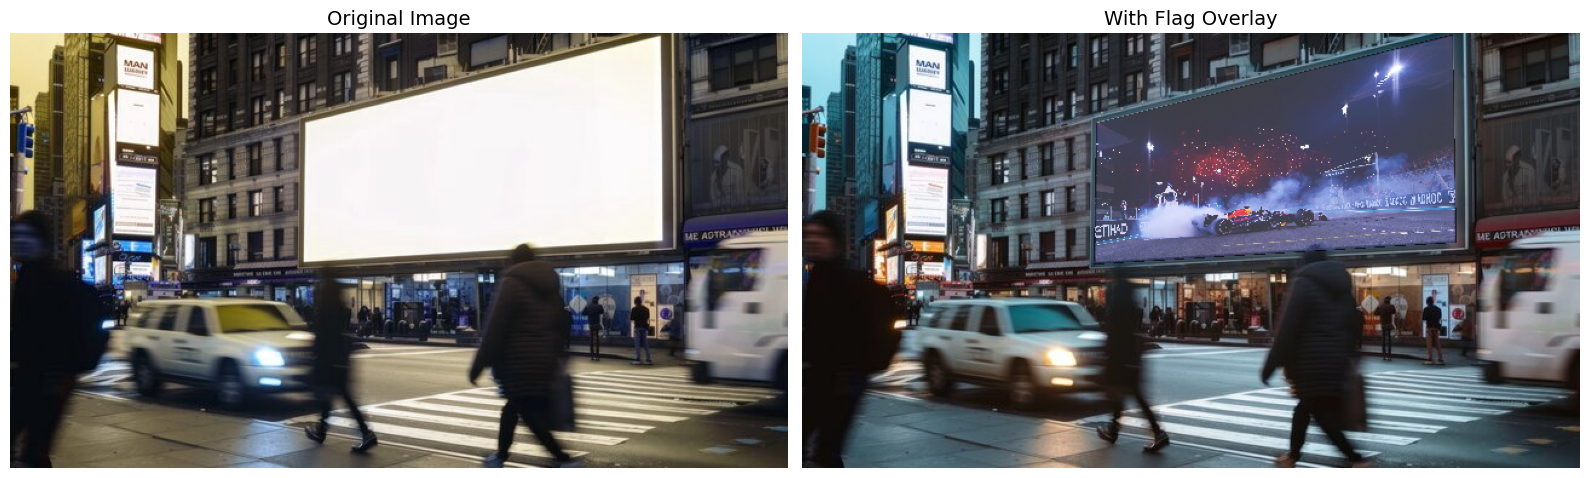

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(billboard_img)
axes[0].set_title('Original Image', fontsize=14)
axes[0].axis('off')

axes[1].imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
axes[1].set_title('With Flag Overlay', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()